In [1]:
import sys
import os
os.system("pip install paddlepaddle")
os.system("python -m pip install paddlepaddle-gpu")
os.system("apt-get install zip unzip")

0

In [2]:
os.system("git clone https://github.com/wzmsltw/PaintTransformer")
import sys
sys.path.append('/content/PaintTransformer/inference') # ADD Directory with my Lib

In [3]:
# Libary from progress bar
from tqdm import tqdm

In [4]:
# Libary from write picture
import matplotlib.pyplot as plt

In [5]:
# For job in regular
import glob

In [9]:
import imageio

In [7]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import network
import os
import math
import render_utils
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
import cv2
import render_parallel
import render_serial

def main(input_path, model_path, output_dir, need_animation=False, resize_h=None, resize_w=None, serial=False):
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    input_name = os.path.basename(input_path)
    output_path = os.path.join(output_dir, input_name)
    frame_dir = None
    if need_animation:
        if not serial:
            print('It must be under serial mode if animation results are required, so serial flag is set to True!')
            serial = True
        frame_dir = os.path.join(output_dir, input_name[:input_name.find('.')])
        if not os.path.exists(frame_dir):
            os.mkdir(frame_dir)
    stroke_num = 8

    #* ----- load model ----- *#
    paddle.set_device('gpu')
    net_g = network.Painter(5, stroke_num, 256, 8, 3, 3)
    net_g.set_state_dict(paddle.load(model_path))
    net_g.eval()
    for param in net_g.parameters():
        param.stop_gradient = True

    #* ----- load brush ----- *#
    brush_large_vertical = render_utils.read_img('/content/PaintTransformer/inference/brush/brush_large_vertical.png', 'L')
    brush_large_horizontal = render_utils.read_img('/content/PaintTransformer/inference/brush/brush_large_horizontal.png', 'L')
    meta_brushes = paddle.concat([brush_large_vertical, brush_large_horizontal], axis=0)

    import time
    t0 = time.time()
    
    original_img = render_utils.read_img(input_path, 'RGB', resize_h, resize_w)
    if serial:
        final_result_list = render_serial.render_serial(original_img, net_g, meta_brushes)
        if need_animation:

            print("total frame:", len(final_result_list))
            for idx, frame in enumerate(final_result_list):
                cv2.imwrite(os.path.join(frame_dir, '%03d.png' %idx), frame)
        else:
            cv2.imwrite(output_path, final_result_list[-1])
    else:
        final_result = render_parallel.render_parallel(original_img, net_g, meta_brushes)
        cv2.imwrite(output_path, final_result)
    
    print("total infer time:", time.time() - t0)

if __name__ == '__main__':
    
    main(input_path='/content/PaintTransformer/inference/input/kazan.jpg',
         model_path='/content/PaintTransformer/paint_best.pdparams',
         output_dir='output/',
         need_animation=True,  # whether need intermediate results for animation.
         resize_h=512,         # resize original input to this size. None means do not resize.
         resize_w=512,         # resize original input to this size. None means do not resize.
         serial=False)          # if need animation, serial must be True.

     

It must be under serial mode if animation results are required, so serial flag is set to True!
layer 0 cost: 0.38
layer 1 cost: 0.37
layer 2 cost: 0.56
layer 3 cost: 1.26
layer 4 cost: 3.85
total frame: 171
total infer time: 8.981174230575562


In [64]:


def creator_video(path, output_name_video, fps_ = 30, reverse_ = False):
  """
  @path -> путь к папке с фотографиями (одного разрешения и в алфавитномм пордяке)
  @output_name_video -> название выходного видео
  @fps_ -> количество кадров в секунду
  @reverse_ -> включение обратного порядка в видео
  """
  fileList = []
  
  for file in os.listdir(path):
      complete_path = path + '/'+ file
      fileList.append(complete_path)
  
  fileList.sort(reverse = reverse_)
  
  writer = imageio.get_writer(output_name_video, fps = fps_)
  
  for im in tqdm(fileList):
    writer.append_data(imageio.imread(im))
  
  writer.close()
  print('Success create video!!!')


In [10]:
creator_video("/content/output/kazan", "kzn_30fps.mp4")

/usr/local/lib/python3.7/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


Success create video!!!


In [11]:
creator_video("/content/output/kazan", "kzn_10fps_reverse.mp4", fps_ = 10, reverse_= True)

/usr/local/lib/python3.7/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


Success create video!!!


(512, 512, 3)


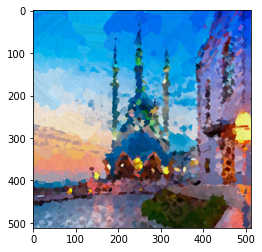

In [14]:

### NumPy array ###
tmp = imageio.imread("/content/output/kazan/169.png")

print(tmp.shape)
plt.imshow(tmp)

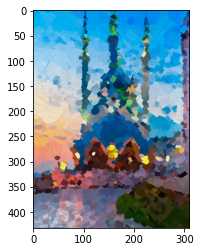

In [40]:
#### sub image


image = cv2.imread("/content/output/kazan/169.png", cv2.IMREAD_ANYCOLOR)

rgb_img = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img[80:,90:400])
plt.show()


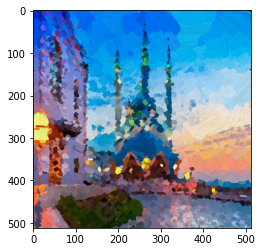

In [44]:
# загружаем изображение и отображаем его
image = cv2.imread("/content/output/kazan/169.png", cv2.IMREAD_ANYCOLOR)

rgb_img = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
# отражаем изображение по вертикальной оси
flipped = cv2.flip(rgb_img, 1)
plt.imshow(flipped)
plt.show()

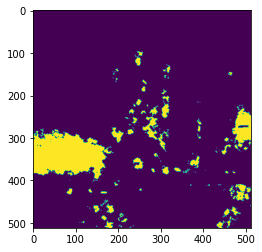

In [58]:
image = cv2.imread("/content/output/kazan/169.png", cv2.IMREAD_ANYCOLOR)

rgb_img = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

# задаем границы диапазона:
# нижнюю
low_color = (0,120,00)
# и верхнюю
high_color = (255,255,250)
# наложение цветовой маски на исходное изображение,
# результат присваиваем переменной only_object
only_object = cv2.inRange(rgb_img, low_color, high_color)
# вывод отфильтрованного изображения на экран
plt.imshow(only_object)
plt.show()


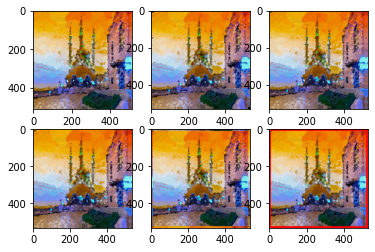

In [60]:
img1 = cv2.imread('/content/output/kazan/169.png')

BLUE = [255,0,0]

replicate = cv2.copyMakeBorder(img1,10,10,10,10,cv2.BORDER_REPLICATE)
reflect = cv2.copyMakeBorder(img1,10,10,10,10,cv2.BORDER_REFLECT)
reflect101 = cv2.copyMakeBorder(img1,10,10,10,10,cv2.BORDER_REFLECT_101)
wrap = cv2.copyMakeBorder(img1,10,10,10,10,cv2.BORDER_WRAP)
constant= cv2.copyMakeBorder(img1,10,10,10,10,cv2.BORDER_CONSTANT,value=BLUE) 

plt.subplot(231),plt.imshow(img1,'gray'),plt.title('')
plt.subplot(232),plt.imshow(replicate,'gray'),plt.title('')
plt.subplot(233),plt.imshow(reflect,'gray'),plt.title('')
plt.subplot(234),plt.imshow(reflect101,'gray'),plt.title('')
plt.subplot(235),plt.imshow(wrap,'gray'),plt.title('')
plt.subplot(236),plt.imshow(constant,'gray'),plt.title('') 
plt.show()

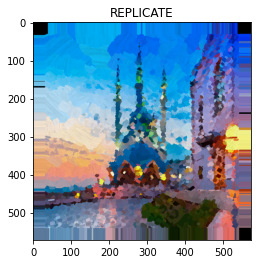

In [61]:
image = cv2.imread("/content/output/kazan/169.png", cv2.IMREAD_ANYCOLOR)

rgb_img = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
replicate = cv2.copyMakeBorder(rgb_img,30,30,30,30,cv2.BORDER_REPLICATE)
plt.imshow(replicate,'gray')
plt.title('REPLICATE')
plt.show()

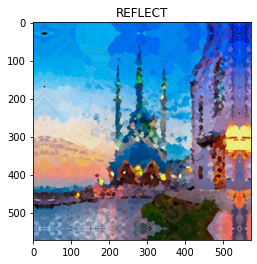

In [62]:
image = cv2.imread("/content/output/kazan/169.png", cv2.IMREAD_ANYCOLOR)

rgb_img = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

replicate = cv2.copyMakeBorder(rgb_img,30,30,30,30, cv2.BORDER_REFLECT)
plt.imshow(replicate)
plt.title('REFLECT')
plt.show()

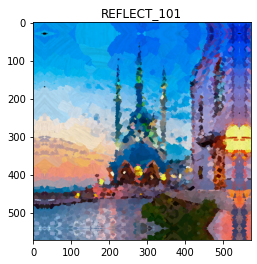

In [63]:
image = cv2.imread("/content/output/kazan/169.png", cv2.IMREAD_ANYCOLOR)

rgb_img = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

replicate = cv2.copyMakeBorder(rgb_img,30,30,30,30, cv2.BORDER_REFLECT_101)
plt.imshow(replicate)
plt.title('REFLECT_101')
plt.show()

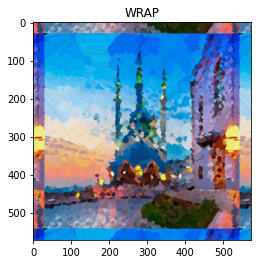

In [64]:
image = cv2.imread("/content/output/kazan/169.png", cv2.IMREAD_ANYCOLOR)

rgb_img = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

replicate = cv2.copyMakeBorder(rgb_img,30,30,30,30, cv2.BORDER_WRAP)
plt.imshow(replicate)
plt.title('WRAP')
plt.show()

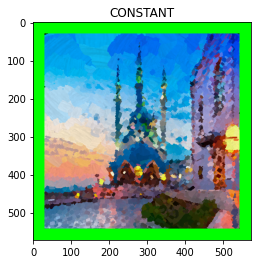

In [66]:
image = cv2.imread("/content/output/kazan/169.png", cv2.IMREAD_ANYCOLOR)

rgb_img = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

replicate = cv2.copyMakeBorder(rgb_img,30,30,30,30, cv2.BORDER_CONSTANT,value=[0,255,0])
plt.imshow(replicate)
plt.title('CONSTANT')
plt.show()

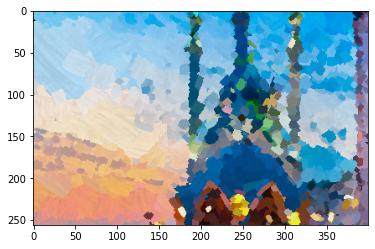

In [69]:
### Crop

from PIL import Image
 
# Opens a image in RGB mode
im = Image.open("/content/output/kazan/169.png")
 
# Size of the image in pixels (size of original image)
# (This is not mandatory)
width, height = im.size
 
# Setting the points for cropped image
left = 0
top = height / 4
right = 400
bottom = 3 * height / 4
 
# Cropped image of above dimension
# (It will not change original image)
im1 = im.crop((left, top, right, bottom))
 
# Shows the image in image viewer
plt.imshow(im1)
plt.show()


[[-1.0000000e+00  1.2246468e-16  1.2000000e+03]
 [-1.2246468e-16 -1.0000000e+00  6.7500000e+02]]


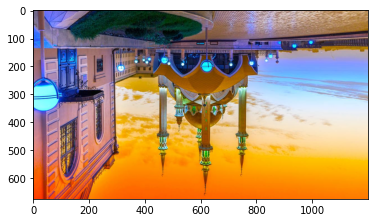

In [36]:
#### Rotate with cv2


image = cv2.imread("/content/PaintTransformer/inference/input/kazan.jpg")
#plt.imshow(image)

# получаем размеры исходного изображения для поворота
(h, w) = image.shape[:2]

# вычислим центр изображения, относительно которого
# выполним поворот
center = (w / 2, h / 2)

# подготовим объект для поворота изображения на 180º
# относительно центра и запишем его в переменную
# prepObj
prepObj = cv2.getRotationMatrix2D(center, 180, 1.0)

print(prepObj)
# повернем исходное изображение на 180°,
# результат запишем в переменную rotated
rotated = cv2.warpAffine(image, prepObj, (w, h))

plt.imshow(rotated)



In [67]:

### img in Image.open for libary from PIL import Image

def saver_img(img, file_name, save_path = os.getcwd()):
  """
  @img -> Image.open type
  @file_name -> название файла котрое хотим сохранить
  @save_path -> папка в которую хотим сохранить
  """
    # Создаем папку если ее нет
  if not os.path.exists(save_path):
        os.makedirs(save_path)
  new_path = save_path + '/' + file_name
  img.save(new_path)

def saver_img_cv(img, file_name, save_path = os.getcwd()):
  """
  @img -> file in cv2.imread
  @file_name -> название файла котрое хотим сохранить
  @save_path -> папка в которую хотим сохранить
  """
  
    # Создаем папку если ее нет
  if not os.path.exists(save_path):
        os.makedirs(save_path)
  new_path = save_path + '/' + file_name
  img = cv2.imwrite(new_path, img)

In [36]:
from PIL import Image
import os

def rotate_img(img, rotate = 180, show = False ):
  """
  @img       -> открытое изображение
  @rotate.   -> поворт на градусы
  @show.     -> показывать измененное изображение
  """
  img = img.rotate(rotate)
  
  if show:
    plt.imshow(img)
  
  return img


In [61]:
from PIL import Image, ImageDraw, ImageFont
## Function in add Counter for image

def add_counter_img(path, save_path = os.getcwd()):
  """
  @path -> путь в котором нахолятся изображения
  @save_path -> куда сохранить измененные изображения
  """
  glob_reg = path + "/" + "*.png"
  lst_num = []
  for file in glob.glob(glob_reg):
    lst_num.append(file)

  lst_num.sort()
  cnt = 0
  for file in tqdm(lst_num):
    cnt += 1
    image = Image.open(file)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf", 25)
    drawer = ImageDraw.Draw(image)
    name = file.split('/')[-1]
    drawer.text((50, 50), str(cnt), font=font, fill='black')
    saver_img(image, name, save_path=save_path)


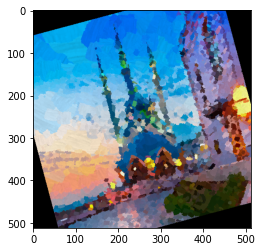

In [37]:
path = "/content/output/kazan/169.png"

img = Image.open(path)

img = rotate_img(img, rotate = 15, show = True)

file_name = path.split('/')[-1]

saver_img(img, file_name)

In [48]:
def read_img(img_path, show = False):
  # NUM PY array
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  # Other parametrs
  # img = cv2.resize(img, (1024, 1024), interpolation = cv2.INTER_NEAREST) ...
  if show:
    plt.imshow(img)
  return img  

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0  63]
 [  0   0   0 ...  62  62  61]
 ...
 [159 159 160 ... 106 117 117]
 [115 115 121 ... 107 108   0]
 [115 114 114 ... 107 108   0]]


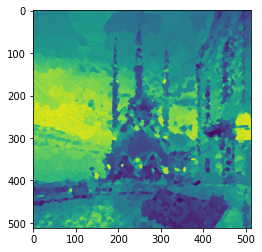

In [46]:
read_img("/content/output/kazan/169.png", show = True)

In [55]:
 

def crawling_folder_img(path, save_path = os.getcwd(), format = "*.png"):
  glob_reg = path + '/' + format
  for file in tqdm(glob.glob(glob_reg)):
    img = read_img(file)
    
    file_name = file.split('/')[-1]
    
    saver_img_cv(img, file_name, "/content/output/kazan_new")

crawling_folder_img("/content/output/kazan" )

100%|██████████| 171/171 [00:02<00:00, 82.38it/s]


In [62]:
add_counter_img("/content/output/kazan", save_path = "/content/output/kazan_withCnt")

100%|██████████| 171/171 [00:15<00:00, 11.22it/s]


In [66]:
creator_video("/content/output/kazan_withCnt", "kzn_with_cnt.mp4", fps_= 10)

  0%|          | 0/171 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())
100%|██████████| 171/171 [00:02<00:00, 64.79it/s]


Success create video!!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


OK


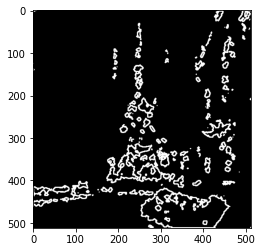

In [349]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
def treshoalding_img(img_path):
    img_1 = cv2.imread(img_path)
    img=cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
    # Basic threhold example
    #th, dst = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY);
    th, dst = cv2.threshold(img, 157, 250, cv2.THRESH_TRUNC);
    #th, dst = cv2.threshold(img, 150, 255, cv2.THRESH_OTSU);
    #th, dst = cv2.threshold(img, 180, 250, cv2.THRESH_TOZERO_INV);
    #th, dst = cv2.threshold(img,  120,255,cv2.THRESH_BINARY_INV);
    countours,hierarchy = cv2.findContours(dst, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    
    cv2.drawContours(img_1, countours,-1,(0,255,0),3)
    #plt.imshow(img_1)
    plt.imshow(dst)
    return dst


def treshoalding_img(img_path):
  img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED) #convert img to grey img_grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  #set a thresh
  thresh = 55
  #get threshold image
  ret,thresh_img = cv2.threshold(img_grey, thresh, 185, cv2.THRESH_BINARY_INV) 
  
  #find contours
  
  contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
  cnt = contours[0]
  #create an empty image for contours
  
  rect = cv2.minAreaRect(cnt)
  box = cv2.boxPoints(rect)
  box = np.int0(box)
  

  img_contours = np.zeros(img.shape) 
  
  im = cv2.drawContours(img,[box],0,(0,0,255),2)
  # draw the contours on the empty image
  
  cv2.drawContours(img_contours, contours, -1, (255,255,255), 2, cv2.LINE_AA, hierarchy, 0)
  cv2.drawContours(img_contours, contours, -1, (255,255,255), 2, cv2.LINE_AA, hierarchy, 2)
  #cv2.imwrite('/content/output/1.png', img_contours)
  plt.imshow(img_contours)





treshoalding_img("/content/output/kazan/170.png")
print('OK')

# for file in tqdm(glob.glob('/content/output/kazan/*.png')):
#     img = treshoalding_img(file)
#     img = cv2.imwrite(file, img)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


OK


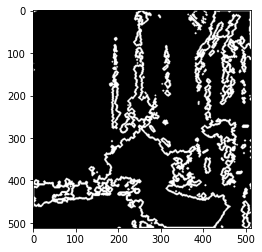

In [242]:
def treshoalding_img(img_path):
  img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED) #convert img to grey img_grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  #set a thresh
  thresh = 85
  #get threshold image
  ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY_INV) 
  
  #find contours
  
  contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
  
  #create an empty image for contours
  
  img_contours = np.zeros(img.shape) 
  
  # draw the contours on the empty image
  
  cv2.drawContours(img_contours, contours, -1, (255,255,255), 3)

  #cv2.imwrite('/content/output/1.png', img_contours)
  plt.imshow(img_contours)





treshoalding_img("/content/output/kazan/170.png")
print('OK')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


OK


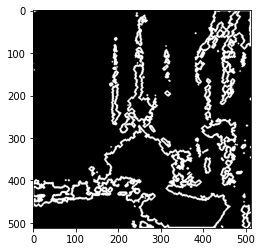

In [243]:
def treshoalding_img(img_path):
  img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED) #convert img to grey img_grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  #set a thresh
  thresh = 80
  #get threshold image
  ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY_INV) 
  
  #find contours
  
  contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
  
  #create an empty image for contours
  
  img_contours = np.zeros(img.shape) 
  
  # draw the contours on the empty image
  
  cv2.drawContours(img_contours, contours, -1, (255,255,255), 3)

  #cv2.imwrite('/content/output/1.png', img_contours)
  plt.imshow(img_contours)





treshoalding_img("/content/output/kazan/170.png")
print('OK')